# Data Preparation: Stationarization

Stationary datasets are those that have a stable mean and variance, and are in turn much easier to model. When modeling, there are assumptions that the summary statistics of observations are consistent.

- A time series is stationary in the mean if $\mu(t)=\mu$, i.e.mean is constant with time. Trends can result in a varying mean over time.
- A time series is stationary in the variance if $\sigma^2(t)=\sigma^2$, i.e. variance is constant with time. Seasonality can result in a changing variance over time

There are some finer-grained notions of stationarity that you may come across if you dive deeper into this topic. They are:

- Stationary Process: A process that generates a stationary series of observations.
- Stationary Model: A model that describes a stationary series of observations.
- Trend Stationary: A time series that does not exhibit a trend.
- Seasonal Stationary: A time series that does not exhibit seasonality.
- Strictly Stationary: A mathematical definition of a stationary process, specifically that the joint distribution of observations is invariant to time shift

Methods to make time series stationary:

- differencing the series (once or more until approx. stationary - most common)
- de-seasonalize the series
- de-trend the series (remove seasonality before trend, because they interact linearly)
- taking the log of the series
- taking the n-th root of the series
- a combination of the above listed options

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from pandas.plotting import autocorrelation_plot
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller
plt.style.use("seaborn-whitegrid")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Test for Stationarity

Here are some common stationarity tests:

- Summary statistics (split in 2 or more and compare)
- Visualizations (series plot & autocorrelation)
- Unit root tests (ADF, KPSS, ZA, PP, Variance-Ratio, etc.) 

In [2]:
# example data
url = "https://raw.githubusercontent.com/selva86/datasets/master/a10.csv"
df = pd.read_csv(url, parse_dates=["date"], index_col="date")
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [3]:
# compare statistics
idx_half = np.int(df.shape[0]/2)
print(df.iloc[:idx_half].describe())
print(df.iloc[idx_half:].describe())

            value
count  102.000000
mean     6.005927
std      1.959892
min      2.814520
25%      4.430718
50%      5.832913
75%      7.286051
max     11.532974
            value
count  102.000000
mean    15.382932
std      4.804415
min      7.457199
25%     11.973305
50%     14.346389
75%     18.076590
max     29.665356


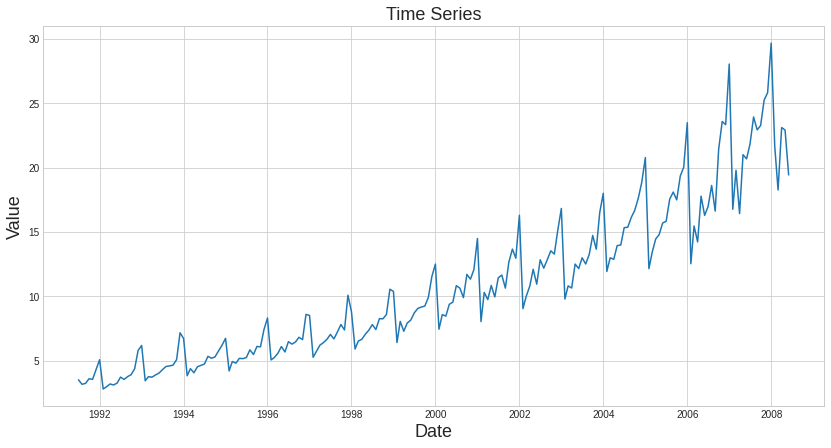

In [4]:
# plot series
plt.figure(figsize=(14,7))
plt.plot(df.index, df["value"])
plt.title("Time Series", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Value", fontsize=18)
plt.show()

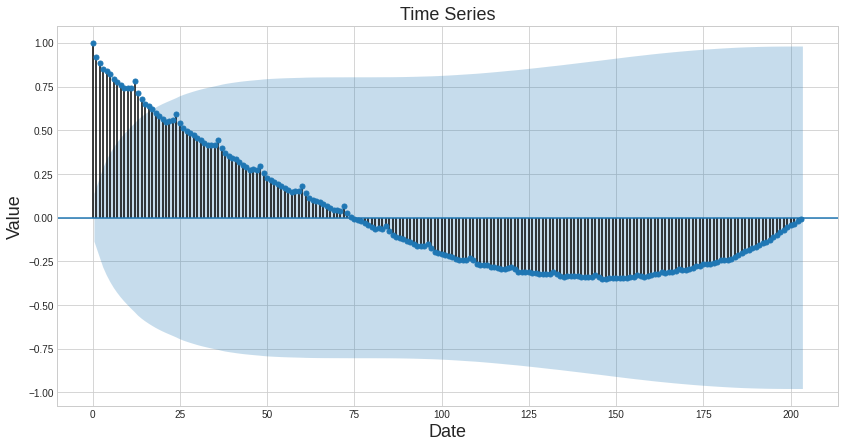

In [5]:
# plot autocorrelation
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 7))
plot_acf(df["value"].tolist(), lags=df["value"].shape[0]-1, ax=axes)
plt.title("Time Series", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Value", fontsize=18)
plt.show()

In [6]:
# ADF (H0: non-stationary)
def adf_stationarity_test(signal):
  result_adf = adfuller(signal, autolag="AIC")
  statistic = result_adf[0]
  p_value = result_adf[1]
  used_lag = result_adf[2]
  nobs = result_adf[3]
  critical_values = result_adf[4]
  icbest = result_adf[5]
  print("________________________________")
  print(" > ADF: Is the data stationary ?")
  print(f'ADF Statistic: {statistic}')
  print(f'p-value: {p_value}')
  print(f'num lags: {used_lag}')
  print('Critial Values:')

  for key, value in critical_values.items():
      print(f'   {key}, {value}')  

  print(f'\nResult: The series is likely {"not " if p_value > 0.05 else ""}stationary')
  print("________________________________")

In [7]:
# KPSS test around constant (H0: stationary around constant)
def kpss_constant_stationarity_test(signal):
  result_kpss_c = kpss(signal, regression="c")

  statistic = result_kpss_c[0]
  p_value = result_kpss_c[1]
  n_lags = result_kpss_c[2]
  critical_values = result_kpss_c[3]

  print("________________________________")
  print(" > KPSS: Is the data stationary around a constant ?")
  print(f'KPSS Statistic: {statistic}')
  print(f'p-value: {p_value}')
  print(f'num lags: {n_lags}')
  print('Critial Values:')

  for key, value in critical_values.items():
    print(f'   {key} : {value}')
    
  print(f'\nResult: The series is likely {"not " if p_value < 0.05 else ""}stationary around a constant')
  print("________________________________")

In [8]:
# KPSS test around trend (H0: stationary around trend)
def kpss_trend_stationarity_test(signal):
  result_kpss_ct = kpss(signal, regression="ct")

  statistic = result_kpss_ct[0]
  p_value = result_kpss_ct[1]
  n_lags = result_kpss_ct[2]
  critical_values = result_kpss_ct[3]

  print("________________________________")
  print(" > KPSS: Is the data stationary around a trend ?")
  print(f'KPSS Statistic: {statistic}')
  print(f'p-value: {p_value}')
  print(f'num lags: {n_lags}')
  print('Critial Values:')

  for key, value in critical_values.items():
    print(f'   {key} : {value}')
    
  print(f'\nResult: The series is likely {"not " if p_value < 0.05 else ""}stationary around a trend')
  print("________________________________")

In [9]:
adf_stationarity_test(df["value"])
kpss_constant_stationarity_test(df["value"])
kpss_trend_stationarity_test(df["value"])

________________________________
 > ADF: Is the data stationary ?
ADF Statistic: 3.145185689306741
p-value: 1.0
num lags: 15
Critial Values:
   1%, -3.465620397124192
   5%, -2.8770397560752436
   10%, -2.5750324547306476

Result: The series is likely not stationary
________________________________
________________________________
 > KPSS: Is the data stationary around a constant ?
KPSS Statistic: 1.3136750533447588
p-value: 0.01
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739

Result: The series is likely not stationary around a constant
________________________________
________________________________
 > KPSS: Is the data stationary around a trend ?
KPSS Statistic: 0.2898018745725043
p-value: 0.01
num lags: 15
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216

Result: The series is likely not stationary around a trend
________________________________


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


## Differencing

Differencing is performed by subtracting the previous observation from the current observation.

`difference(t) = observation(t) - observation(t-1)`

Inverting the process is required when a prediction must be converted back into the original scale. This process can be reversed by adding the observation at the prior time step to the difference value.

`inverted(t) = differenced(t) + observation(t-1)`

This procedure may be applied consecutively more than once, giving rise to the "first differences", "second differences", etc. The number of times that differencing is performed is called the difference order.

- 1st differences: $d^{(1)} (t)=x(t)-x(t-1)$
- 2nd differences: $d^{(2)} (t)=d^{(1)} (t)-d^{(1)} (t-1)$
- m-th differences: $d^{(m)} (t)=d^{(m-1)} (t)-d^{(m-1)} (t-1)$

For time series with a seasonal component, the lag may be expected to be the period (width) of the seasonality.



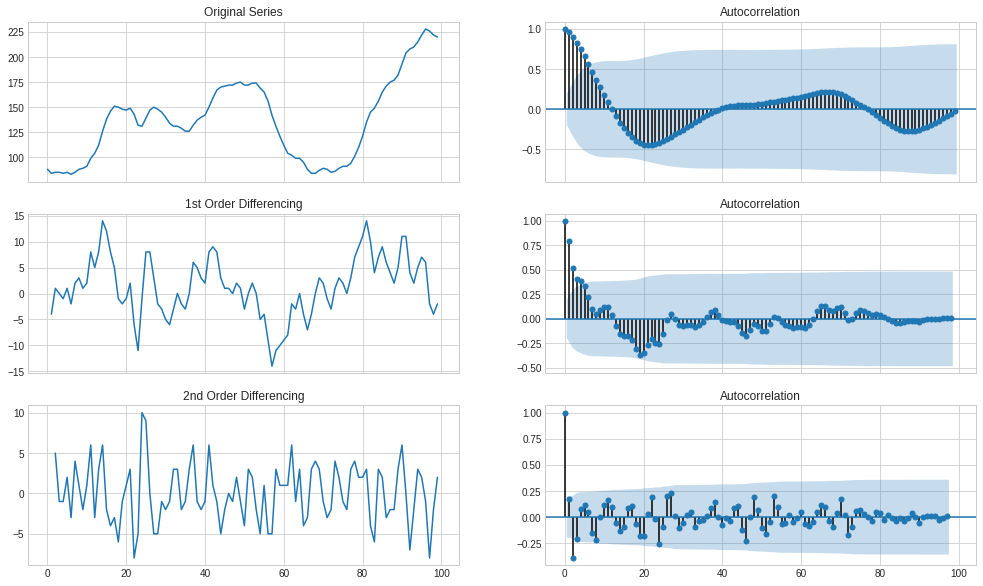

In [10]:
# example data
url = "https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv"
df = pd.read_csv(url, names=['value'], header=0)

# plot
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(17,10))

# Original Series
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, lags=99, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), lags=98, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), lags=97, ax=axes[2, 1])

plt.show()

## De-Trending

Detrending a time series means to remove the trend component from a time series.

Approaches:

- Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms (x^2) in the model.
- Subtract the trend component obtained from time series decomposition.
- Subtract the mean
- Apply a filter like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.

In [11]:
# example data
url = "https://raw.githubusercontent.com/selva86/datasets/master/a10.csv"
df = pd.read_csv(url, parse_dates=["date"], index_col="date")

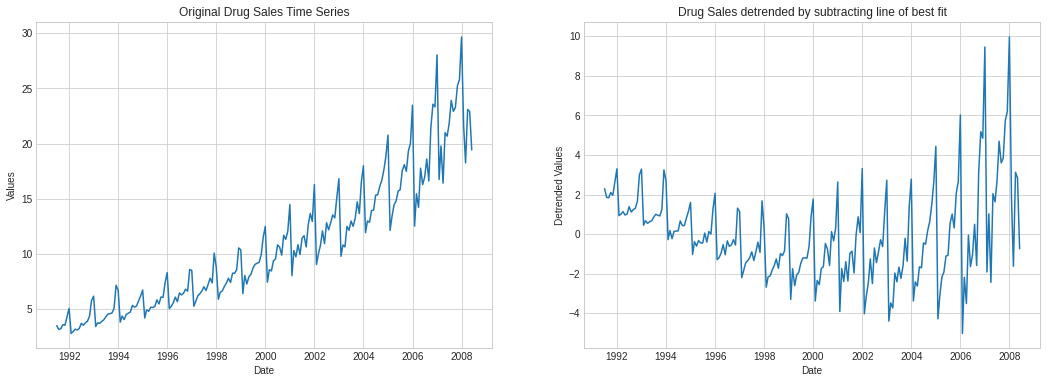

In [12]:
# detrend by subtracting line of best fit
detrended_series = signal.detrend(df["value"].values)

# plot original next to detrended time series
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

axes[0].set_title("Original Drug Sales Time Series")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Values')
axes[0].plot(df.index, df["value"])

axes[1].set_title("Drug Sales detrended by subtracting line of best fit")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Detrended Values')
axes[1].plot(df.index, detrended_series)

plt.show()

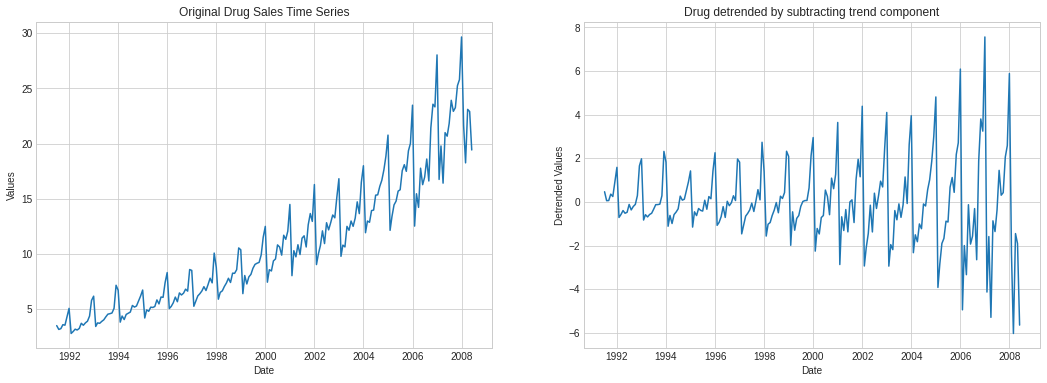

In [13]:
# detrend by subtracting trend component
multi_decomp = seasonal_decompose(df["value"], model="multiplicative", extrapolate_trend="freq")
detrended_series = df["value"] - multi_decomp.trend

# plot original next to detrended time series
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

axes[0].set_title("Original Drug Sales Time Series")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Values')
axes[0].plot(df.index, df["value"])

axes[1].set_title("Drug detrended by subtracting trend component")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Detrended Values')
axes[1].plot(df.index, detrended_series)

plt.show()

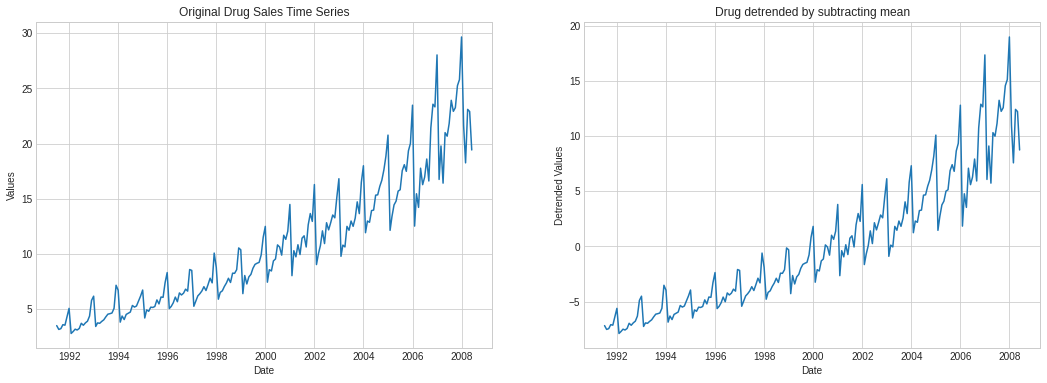

In [14]:
# detrend by subtracting mean
series_mean = df["value"].mean()
detrended_series = df["value"] - series_mean


# plot original next to detrended time series
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

axes[0].set_title("Original Drug Sales Time Series")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Values')
axes[0].plot(df.index, df["value"])

axes[1].set_title("Drug detrended by subtracting mean")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Detrended Values')
axes[1].plot(df.index, detrended_series)

plt.show()

## De-Seasonalization

Deseasonalizing a time series means to remove the seasonality component from a time series.

Approaches:

- take a moving average with length as the seasonal window (this will smoothen the series).
- seasonal difference the time series (subtract the value of the previous season from the current value)
- divide the series by the seasonal index obtained from STL decomposition (seasonal and trend decomposition using Loess). If dividing by the seasonal index does not work well, try taking a log of the series and then do the deseasonalizing. You can later restore to the original scale by taking an exponential.

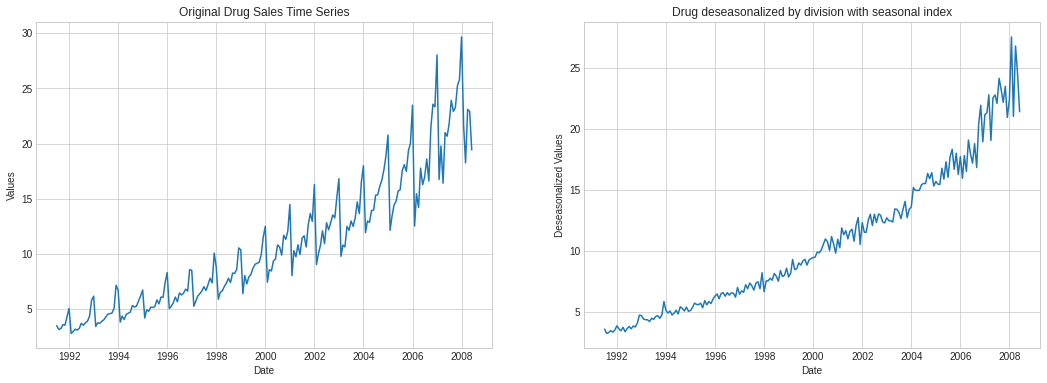

In [15]:
# time series decomposition
multi_decomp = seasonal_decompose(df["value"], model="multiplicative", extrapolate_trend="freq")

# deseasonalize
deseasonalized_series = df["value"] / multi_decomp.seasonal

# plot original next to deseasonalized time series
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

axes[0].set_title("Original Drug Sales Time Series")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Values')
axes[0].plot(df.index, df["value"])

axes[1].set_title("Drug deseasonalized by division with seasonal index")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Deseasonalized Values')
axes[1].plot(df.index, deseasonalized_series)

plt.show()

## Example Combination

- Log series
- Subtract log of trend
- Divide by seasonal index

In [16]:
# plot decomposition
def plot_decomposition(decomposition, axes, title=""):
  axes[0].set_title(title, fontsize=14)
  decomposition.observed.plot(ax=axes[0], legend=False)
  axes[0].set_ylabel('Observed')
  decomposition.trend.plot(ax=axes[1], legend=False)
  axes[1].set_ylabel('Trend')
  decomposition.seasonal.plot(ax=axes[2], legend=False)
  axes[2].set_ylabel('Seasonal')
  decomposition.resid.plot(ax=axes[3], legend=False)
  axes[3].set_ylabel('Residual')
  plt.show()

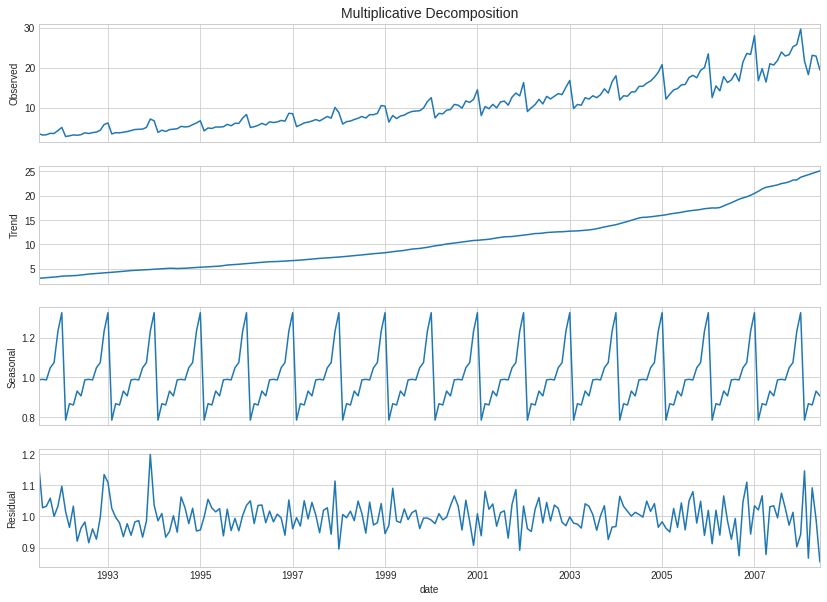

In [17]:
# multiplicative decomposition
multi_decomp = seasonal_decompose(df["value"], model="multiplicative", extrapolate_trend="freq")

# plot multiplicative decomposition
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(14,10))
plot_decomposition(multi_decomp, axes, "Multiplicative Decomposition")

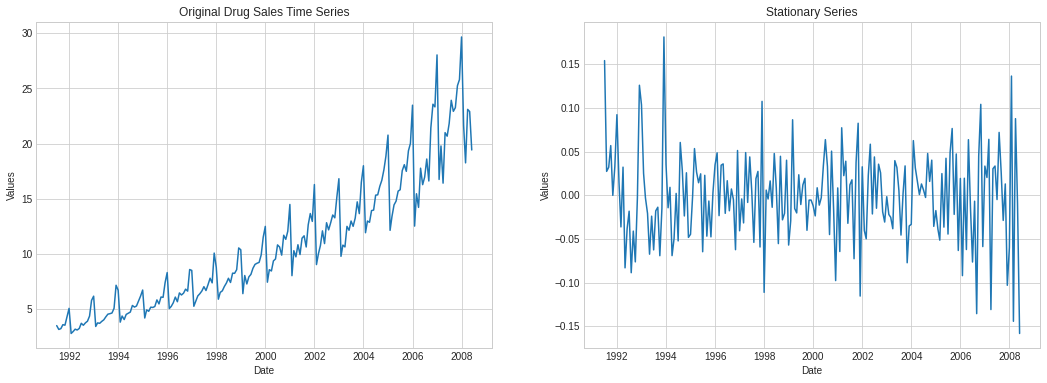

In [18]:
# time series decomposition
multi_decomp = seasonal_decompose(df["value"], model="multiplicative", extrapolate_trend="freq")

# deseasonalize via division with seasonal variable
stationary_series = df["value"] / multi_decomp.seasonal

# log the deseaonalized series
stationary_series = np.log(stationary_series)

# detrend by subtracting log of trend variable
stationary_series = stationary_series - np.log(multi_decomp.trend)

# plot original next to deseasonalized time series
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

axes[0].set_title("Original Drug Sales Time Series")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Values')
axes[0].plot(df.index, df["value"])

axes[1].set_title("Stationary Series")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Values')
axes[1].plot(df.index, stationary_series)

plt.show()

In [19]:
adf_stationarity_test(stationary_series)
kpss_constant_stationarity_test(stationary_series)
kpss_trend_stationarity_test(stationary_series)

________________________________
 > ADF: Is the data stationary ?
ADF Statistic: -8.10383144107857
p-value: 1.2785626971934577e-12
num lags: 10
Critial Values:
   1%, -3.4646940755442612
   5%, -2.8766348847254934
   10%, -2.5748163958763994

Result: The series is likely stationary
________________________________
________________________________
 > KPSS: Is the data stationary around a constant ?
KPSS Statistic: 0.22392810028298124
p-value: 0.1
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739

Result: The series is likely stationary around a constant
________________________________
________________________________
 > KPSS: Is the data stationary around a trend ?
KPSS Statistic: 0.0652912102547095
p-value: 0.1
num lags: 15
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216

Result: The series is likely stationary around a trend
________________________________


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
